# Plan

1. Research earthquakes, research common earthquake classification methods
2. Get oriented with data, see if we can find any patterns
3. Decide on ML or non-ML approach

## ML approach plan options:

CNN (convolutional neural network)
- feed the model all the different times in each dataset, labeled as "arrival" or "not arrival"
- use the relationship between the velocities of different time steps to form a model classifying "arrival" or not.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from obspy import read
import math
import cProfile

In [2]:
dir_name = 'data/lunar/training'
catalog_name = 'apollo12_catalog_GradeA_final.csv'

In [5]:
# get catalog dataframe
catalog_df = pd.read_csv(os.path.join(dir_name + '/catalogs/', catalog_name))
catalog_df = catalog_df.drop(catalog_df.index[20]).reset_index(drop=True)
# print(catalog_df.head())
# get list of files
arrival_time_catalog = catalog_df['time_rel(sec)']
filename_catalog = catalog_df['filename']
# make_plot(filename_catalog, arrival_time_catalog)

In [6]:
# make the plot for a csv file
def make_plot(namelist, arrival_time):
  fig, ax = plt.subplots(5, 1, figsize=(10, 20))
  # for i in range(len(namelist)):
  for i in range(len(namelist.head())):
    df = pd.read_csv(os.path.join(dir_name + '/data/S12_GradeA', namelist[i] + '.csv'))
    times = np.array(df['time_rel(sec)'].tolist())
    data = np.array(df['velocity(m/s)'].tolist())
    ax[i].plot(times, data)
    ax[i].set_xlabel('Time (s)')
    ax[i].set_ylabel('Velocity (m/s)')
    ax[i].axvline(x = arrival_time[i], color='red',label='Rel. Arrival')
    arrival_line = ax[i].axvline(x=arrival_time[i], c='red', label='Abs. Arrival')
    ax[i].legend(handles=[arrival_line])

In [ ]:
# make_plot(filename_catalog[2])

# Machine Learning Section - LSTM


pairs to be fixed:
7,8
21,22
35,36
47,48
66,67

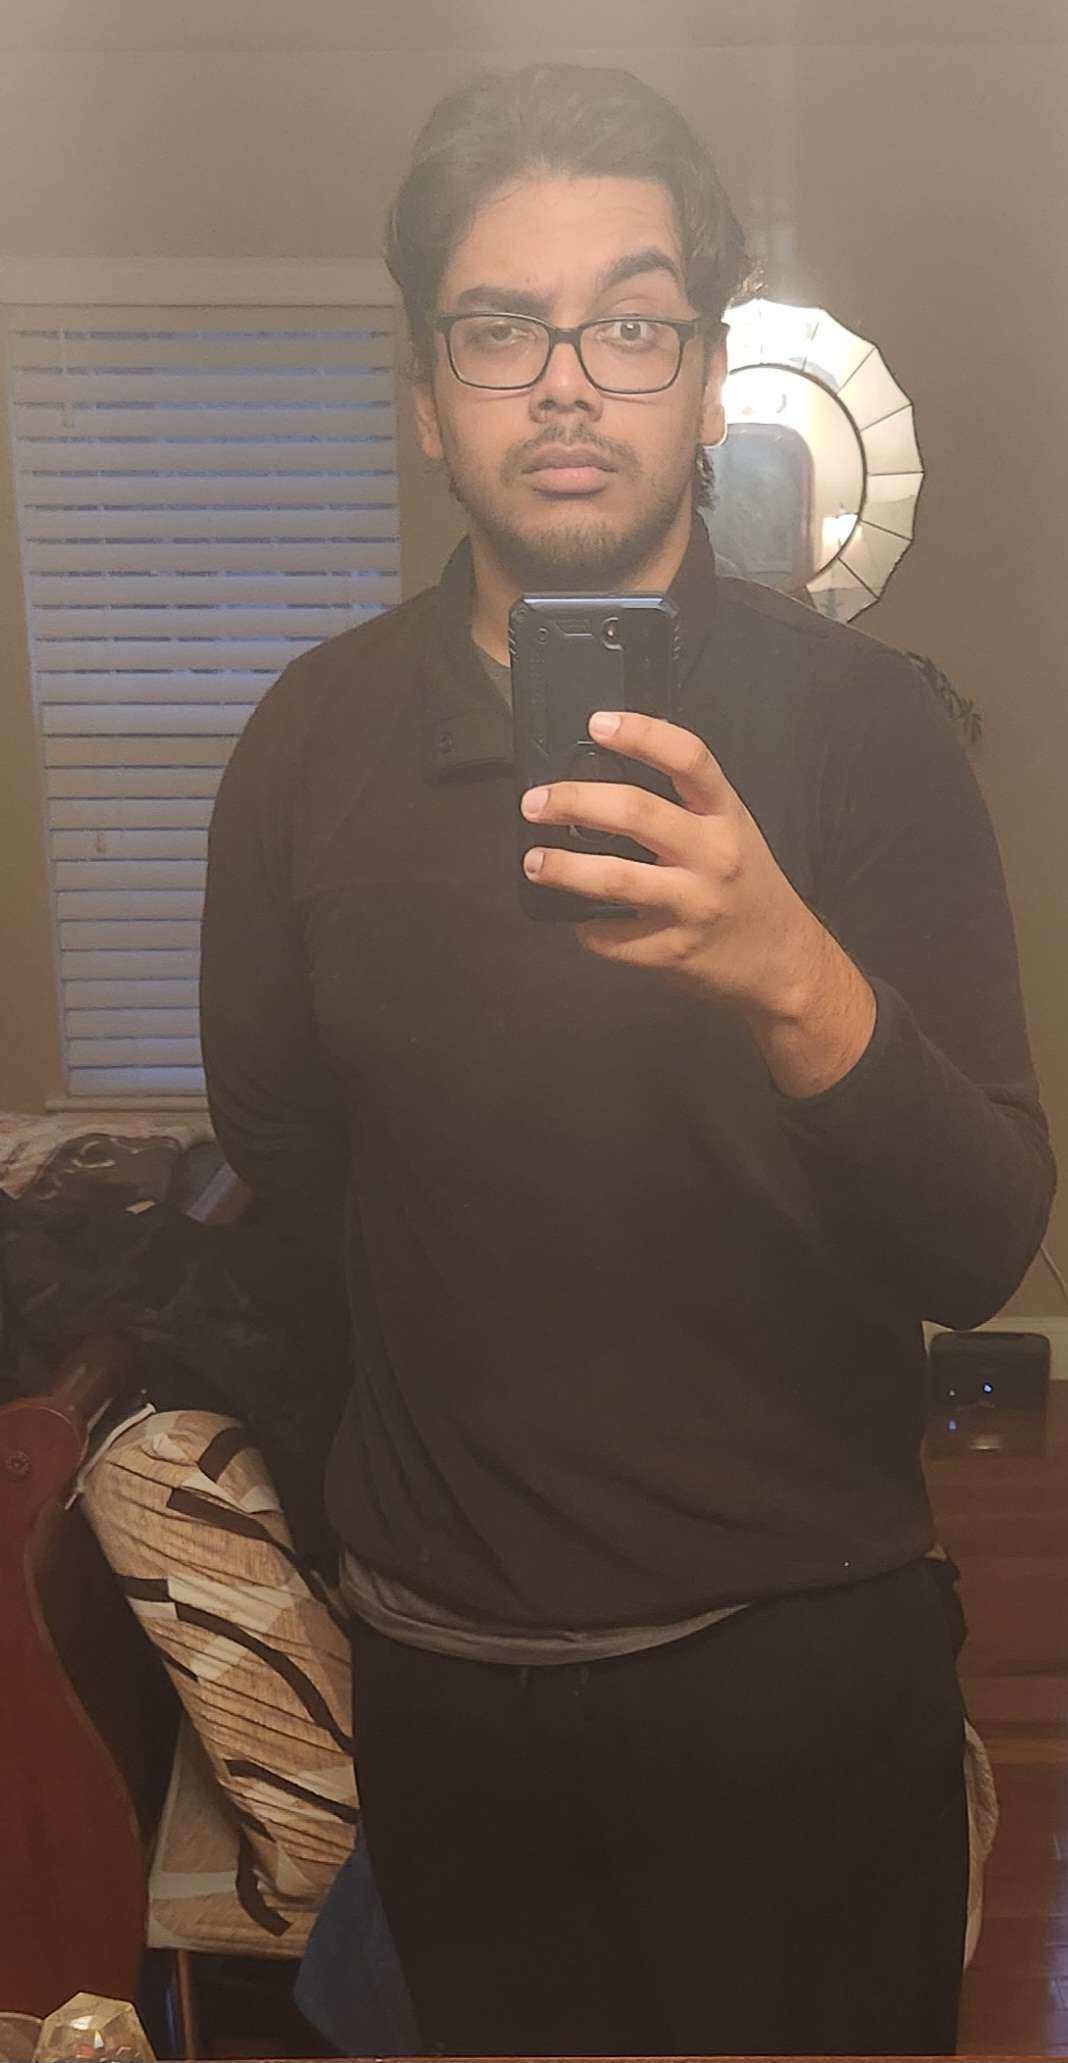

# New Version

Version 3

In [7]:
# split a csv into windows
def makeWindows(df, arrival_times, b_bound = 2, f_bound = 6, jump = 50):
  # print(df, arrival_times)
  arrival_indices = []
  # print(df['time_rel(sec)'].tolist()[48500:48900])
  for arrival_time in arrival_times:
    time_list = df['time_rel(sec)'].tolist()
    for i in range(len(time_list)):
      if math.isclose(time_list[i], arrival_time, abs_tol=0.1):
        # print(time_list[i], arrival_time)
        arrival_indices += [i]
        break
  velocities = df['velocity(m/s)'].tolist()

  result = []
  for offset in range(0, jump):
    f_pointer = (b_bound + f_bound) * jump + offset
    result = result + [[velocities[0: f_pointer:jump], False]]
    f_pointer += jump


    while f_pointer < len(velocities):
      target = f_pointer - (f_bound * jump)
      classification = False
      if target in arrival_indices:
        classification = True
      result.append([result[-1][0][1:] + [velocities[f_pointer]], classification])
      f_pointer += jump

  return result

In [8]:
def make_many_windows(count = catalog_df.shape[0], jumps = 50):
  windows_df = pd.DataFrame(columns=['window', 'classification'])

  duplicates = {7:8, 21:22, 35:36, 47:48, 66:67}
  for i in range(count):
    if i in duplicates.values():
      continue

    arrival_times = [catalog_df.loc[i, 'time_rel(sec)']]
    if i in duplicates.keys():
      arrival_times.append(catalog_df.loc[duplicates[i], 'time_rel(sec)'])

    filename = catalog_df.loc[i, 'filename']
    csv_df = pd.read_csv(os.path.join(dir_name + '/data/S12_GradeA/', filename + '.csv'))
    new_windows = pd.DataFrame(makeWindows(csv_df, arrival_times, jump = jumps), columns=['window', 'classification'])
    windows_df = pd.concat([windows_df, new_windows])
  return windows_df



In [10]:
# cProfile.run("make_one_window()")
windows_df = make_many_windows(20)

In [12]:
temp_df = windows_df.query('classification == True')
print(temp_df.head(10))
print(temp_df.iloc[0,0])

                                                   window classification
433031  [-3.723378905903512e-10, 1.1130096336027927e-0...           True
230494  [-1.9635943705120223e-10, -2.8390161739232336e...           True
89760   [-1.1627175358013935e-10, -2.5693141420134256e...           True
172201  [2.9728677899237624e-10, 1.6676200219985537e-1...           True
315797  [5.330479132649831e-12, 2.9728208438875485e-10...           True
9061    [1.0751961955724324e-10, 5.833471001562563e-10...           True
547248  [-1.6997540722168103e-10, -3.872939765018343e-...           True
402841  [3.1980663250146814e-11, -1.3775161716234722e-...           True
463205  [3.2863412166777265e-10, -2.9877942713563827e-...           True
89601   [1.2690703919482512e-12, 1.6445242940405202e-1...           True
[-3.723378905903512e-10, 1.1130096336027927e-09, 6.722989909479168e-10, 1.3185041413415143e-09, 6.365836694219063e-10, -4.742486246977076e-10, 3.1071585010038037e-11, -6.122707572106535e-11, 3.6683

In [13]:
windows_df

,window,classification
0,"[-6.153278962788711e-14, -4.0231967094196936e-...",False
1,"[-4.0231967094196936e-15, -4.834471003261831e-...",False
2,"[-4.834471003261831e-15, -2.374202804578299e-1...",False
3,"[-2.374202804578299e-15, -2.85616945537678e-15...",False
4,"[-2.85616945537678e-15, 4.638873676341524e-15,...",False
...,...,...
572022,"[4.0916856076953674e-13, -5.394413107166994e-1...",False
572023,"[-5.394413107166994e-13, -4.0983000671240844e-...",False
572024,"[-4.0983000671240844e-13, 1.8727645246361492e-...",False
572025,"[1.8727645246361492e-14, -2.0450441355628337e-...",False


# Model Training

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


In [16]:
df = windows_df

In [21]:
X = pd.DataFrame(df['window'].tolist())
X_clean = X.dropna(axis = 1, how = 'any')
y = df['classification'].astype(int)
X_clean.head()

,0,1,2,3,4,5,6,7
0,-6.153279e-14,-4.023197e-15,-4.834471e-15,-2.374203e-15,-2.856169e-15,4.638874e-15,-7.392754e-14,1.197871e-13
1,-4.023197e-15,-4.834471e-15,-2.374203e-15,-2.856169e-15,4.638874e-15,-7.392754e-14,1.197871e-13,-5.045166e-14
2,-4.834471e-15,-2.374203e-15,-2.856169e-15,4.638874e-15,-7.392754e-14,1.197871e-13,-5.045166e-14,2.344681e-14
3,-2.374203e-15,-2.856169e-15,4.638874e-15,-7.392754e-14,1.197871e-13,-5.045166e-14,2.344681e-14,-1.833348e-13
4,-2.856169e-15,4.638874e-15,-7.392754e-14,1.197871e-13,-5.045166e-14,2.344681e-14,-1.833348e-13,3.382311e-13


In [18]:
# Takes 5 seconds to run
model = LogisticRegression(max_iter=1000)
model.fit(X_clean, y)

LogisticRegression(max_iter=1000)

In [22]:
# Takes 4 minutes to run
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_clean, y)

RandomForestClassifier(random_state=42)

# Test Data Processing